In [16]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_31/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<Figure size 432x288 with 0 Axes>

<img src="../../../common/logo_DH.png" align='left' width=50%/>

# Checkpoint Clustering


Vamos a trabajar con un dataset de cáncer de mama elaborado por la Universidad de Wisconsin. Las features fueron calculadas de imágenes digitalizadas de tejido mamario y describen características de los núcleos celulares en las imágenes. Además contamos con una variable categórica que describe si las observaciones corresponden a células benignas o malignas.

Para empezar importamos el dataset de sklearn:


In [17]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
BC = load_breast_cancer()

X=BC.data; # Features
y_true=BC.target; # Target

data=pd.DataFrame(X);
data.columns=BC.feature_names

data['diagnosis']=y_true;

print(BC.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

#### 1. Visualización

Hacé una exploración visual de los datos, para ver si existe una estructura de clusters consistente con las categorías 'Benigna' y 'Maligna'. Los datos tienen 30 dimensiones por lo que hacer un pairplot de todas contra todas se vuelve imposible. Elegí pares de dimensiones que sospeches que puedan ser relevantes y graficá en scatterplots con distinto color las células benignas y malignas. 

Hay alguna combinación de features que separe visualmente las clases?



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [19]:
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [20]:
data.shape

(569, 31)

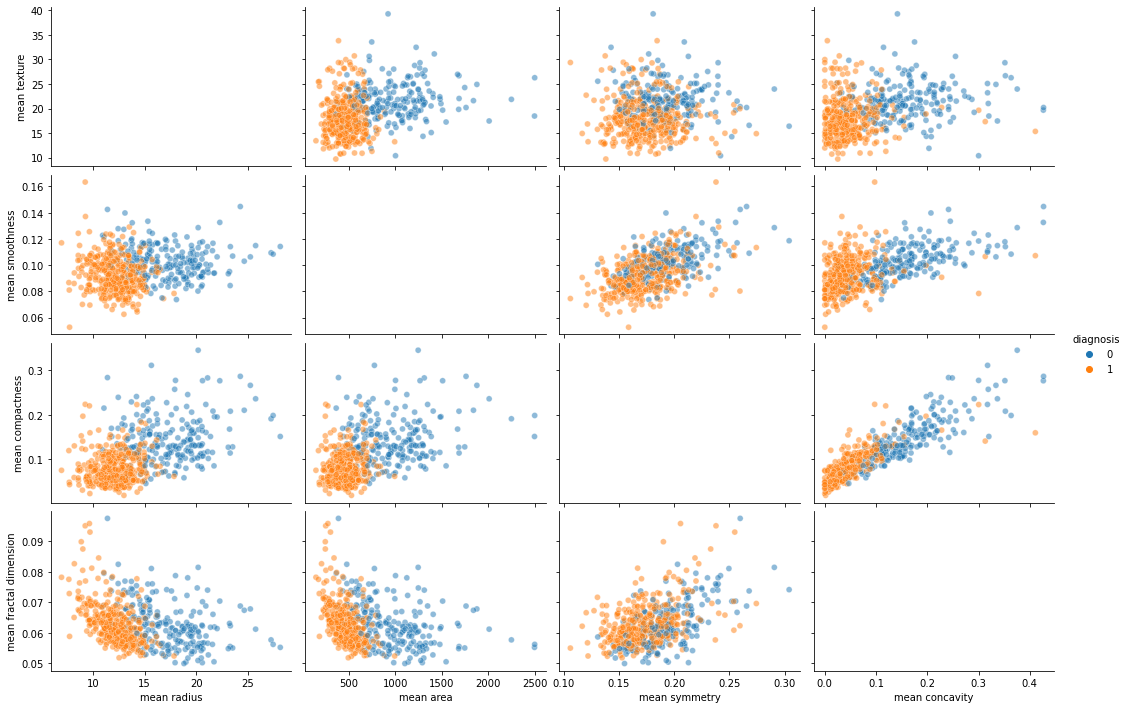

In [21]:
sns.pairplot(data=data,x_vars=['mean radius','mean area','mean symmetry','mean concavity'],\
         y_vars=['mean texture','mean smoothness','mean compactness','mean fractal dimension'],hue='diagnosis',plot_kws={'alpha': 0.5},aspect=1.5);


#### 2. Estandarización

Antes de implementar un algoritmo de clustering, qué hay que hacer con los datos? 



In [25]:
from sklearn.preprocessing import StandardScaler

esc = StandardScaler()

X_esc = esc.fit_transform(X)

#### 2. Kmeans

Empecemos por usar Kmeans, variando k entre 2 y 9. Graficá las medidas silhouette y calinski-harabasz en cada caso. 

¿Qué nos dicen sobre la estructura de los datos? 

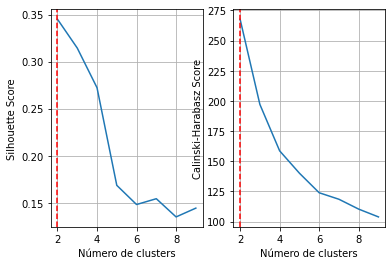

In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

silhouette=[]
calinski=[]
k_values=range(2,10);

for i in k_values:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_esc)
    score=silhouette_score(X_esc, kmeans.labels_) # Etiquetas que indican a qué cluster pertenecen los datos
    score2=calinski_harabasz_score(X_esc, kmeans.labels_)
    silhouette.append(score)
    calinski.append(score2)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(k_values, silhouette)
ax2.plot(k_values, calinski)
ax1.set_ylabel('Silhouette Score')
ax1.set_xlabel('Número de clusters')
ax2.set_ylabel('Calinski-Harabasz Score')    
ax2.set_xlabel('Número de clusters');
ax1.grid()
ax2.grid()
ax1.axvline(x=2, color='r', linestyle='--')

ax2.axvline(x=2, color='r', linestyle='--')
plt.show()
    

####  Evaluación

Dado que conocemos las etiquetas, podemos testear el clustering viendo las métricas que vimos para clasificación.  

* Graficá la matriz de confusión comparando las etiquetas reales con las predichas para el caso en que k=2.

* Usá la herramienta classification_report de sklearn.metrics para evaluar el resultado mirando distintas métricas. 

¿Cuál es la métrica más importante en este caso?

* Graficá en un scatterplot de mean radius vs mean texture los clusters encontrados. Compará visualmente con el scatterplot del punto 1 en donde usamos las etiquetas reales.

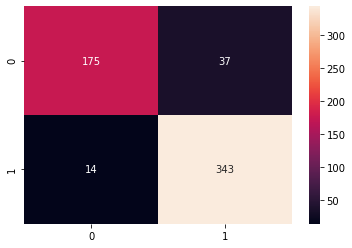

In [80]:
from sklearn.metrics import confusion_matrix, classification_report

k_mean = KMeans(n_clusters=2, random_state=0).fit(X_esc)

labels_k_mean = k_mean.labels_

sns.heatmap(confusion_matrix(y_true,labels_k_mean), annot=True, fmt='.3g')
plt.show()

In [82]:
print(classification_report(y_true, labels_k_mean))

              precision    recall  f1-score   support

           0       0.93      0.83      0.87       212
           1       0.90      0.96      0.93       357

    accuracy                           0.91       569
   macro avg       0.91      0.89      0.90       569
weighted avg       0.91      0.91      0.91       569



#### 3. Clustering Jerárquico

* Implementá un modelo de clustering jerárquico usando el método 'ward' y graficá el dendrograma. ¿Se ve una estructura de clusters? ¿cuántos?

* Seleccioná dos clusters con la función fcluster().

* Graficá la matriz de confusión y el clasification_report para este caso. ¿Cómo performa en relación a kmeans?


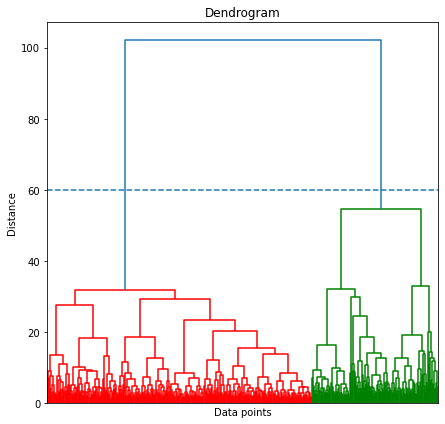

In [88]:
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score,calinski_harabasz_score,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist,squareform


Z = linkage(X_esc, 'ward');

plt.figure(figsize=[7,7])
plt.title('Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')

color_palette=['r','g','y','m','c'];

hierarchy.set_link_color_palette(color_palette) 

dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=5.,  
    color_threshold=60,     
)
plt.hlines(60,0,X_esc.shape[0]*100,linestyle='--')
plt.xticks([])
plt.show()




              precision    recall  f1-score   support

           0       0.89      0.77      0.83       212
           1       0.88      0.94      0.91       357

    accuracy                           0.88       569
   macro avg       0.88      0.86      0.87       569
weighted avg       0.88      0.88      0.88       569



Text(0.5, 1.0, 'Hierarchical Clustering')

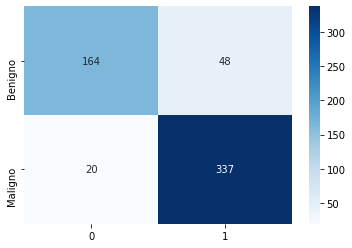

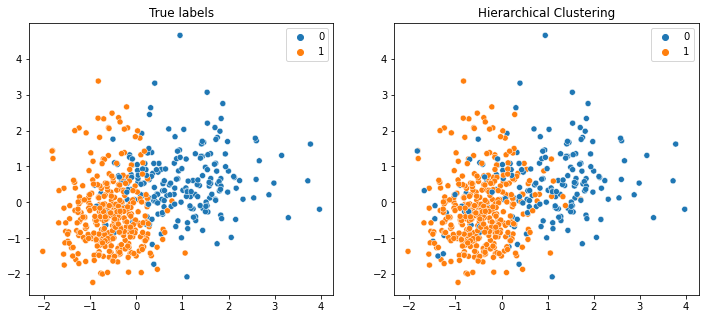

In [92]:
labels_hc=fcluster(Z,2,criterion='maxclust');

labels_hc[labels_hc==2]=0;


sns.heatmap(confusion_matrix(y_true,labels_hc),annot=True,cmap='Blues',fmt=".0f",yticklabels=['Benigno','Maligno']);

print(classification_report(y_true,labels_hc))

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = X_esc[:,0], y = X_esc[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = X_esc[:,0], y = X_esc[:,1],hue=labels_hc,ax=ax[1])
ax[1].set_title('Hierarchical Clustering')

#### 4. DBSCAN

Repetí el el análisis con DBSCAN. Para ello deberás setear los hiperparámetros minPts y eps. 


* Graficá la curva de k-distancias para definir eps. Recordá que se suele usar k=minPts-1. Mirá la curva para distintos valores de minPts razonables.

* Cuántos clusters encuentran con DBSCAN? Depende mucho del valor de los hiperparámetros?

* Graficá los scatterplots correspondientes.



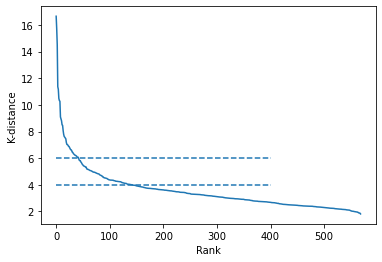

In [95]:
import numpy as np

minPts=20;
k=minPts-1;

D=squareform(pdist(X_esc));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([4,6],0,400,linestyles='dashed');


In [11]:
D.shape

(569, 569)

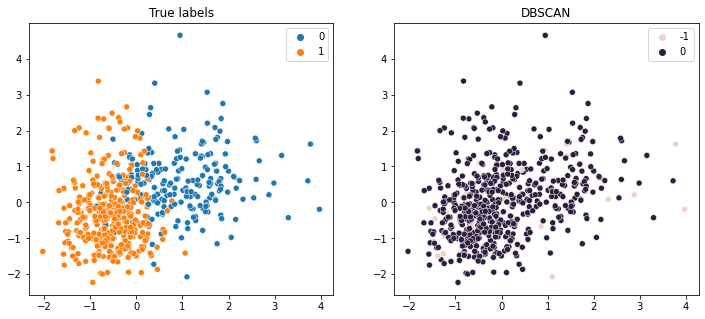

In [98]:
from sklearn.cluster import KMeans,DBSCAN

dbscan = DBSCAN(eps=5, min_samples=minPts)
labels_db = dbscan.fit_predict(X_esc)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = X_esc[:,0], y = X_esc[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = X_esc[:,0], y = X_esc[:,1],hue=labels_db,ax=ax[1])
ax[1].set_title('DBSCAN');
